In [52]:
import torch
import pandas as pd
import os
import glob
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms,models
from torch.utils.data import DataLoader,random_split
from torchvision.models import densenet121
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, roc_curve, auc
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
import Main
from ChexnetTrainer import ChexnetTrainer
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda:0")
print(device)

cuda:0


In [34]:
class PneumoniaDataset(Dataset):
    def __init__(self,data_dir, label_file, transform=None):

        self.data_dir = data_dir
        self.transform = transform
        self.labels_df = pd.read_excel(label_file)
        #if label contains Pneumothorax = 1 else 0 
        self.labels_df['Pneumothorax'] = self.labels_df['Finding Labels'].apply(lambda x: 1 if 'Pneumothorax' in x.split('|') else 0)

        # Separate the majority and minority classes
        df_majority = self.labels_df[self.labels_df['Pneumothorax'] == 0]
        df_minority = self.labels_df[self.labels_df['Pneumothorax'] == 1]

        # Undersample the majority class without replacement
        majority_size = len(df_minority) # same as the minority class size
        df_majority_undersampled = df_majority.sample(n=majority_size, random_state=42)

        # Combine the minority class with the undersampled majority class
        self.labels_df = pd.concat([df_minority, df_majority_undersampled]).reset_index(drop=True)

        # Shuffle the dataset
        self.labels_df = self.labels_df.sample(frac=1, random_state=42).reset_index(drop=True)

        self.image_paths = {os.path.basename(x): x for x in glob.glob(os.path.join(data_dir, '*', 'images', '*.png'))}
        self.labels_df['path'] = self.labels_df['Image Index'].map(self.image_paths.get)
        self.labels_df.dropna(subset=['path'], inplace=True)

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx]['path']
        image = Image.open(img_name).convert('RGB')
        label = self.labels_df.iloc[idx]['Pneumothorax']
        if self.transform:
            image = self.transform(image)
        return image, label
    def get_label_1_paths(self):
        label_1_paths = self.labels_df[self.labels_df['Pneumothorax'] == 1]['path'].tolist()
        return label_1_paths

def get_transforms():  
#resize the image size to 224 x 224 pixels
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform

def get_data_loaders(data_dir, label_file,batch_size=16, val_split=0.1,  test_split=0.1):

    transform = get_transforms()
    dataset = PneumoniaDataset(data_dir=data_dir, label_file=label_file, transform=transform)
    
    # Calculate split sizes
    val_size = int(val_split * len(dataset))
    test_size = int(test_split * len(dataset))
    train_size = len(dataset) - val_size - test_size
    
    # Split the dataset into training, validation, and test sets
    train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataset,val_dataset,train_loader,val_loader,test_dataset,test_loader

In [35]:
# transform = get_transforms()
# test_dataset = PneumoniaDataset(data_dir='../raw_data/archive/', label_file='../raw_data/archive/CXR8-selected/micro.xlsx', transform=transform)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
train_dataset, val_dataset,train_loader, val_loader,test_dataset, test_loader= get_data_loaders(data_dir='../raw_data/archive/', label_file='../raw_data/archive/CXR8-selected/Data_Entry_2017_v2020.xlsx')
#train_dataset, val_dataset,train_loader, val_loader,test_dataset, test_loader= get_data_loaders(data_dir='../raw_data/archive/', label_file='../raw_data/archive/CXR8-selected/micro.xlsx')
print(f"Training Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

# def count_batches(data_loader):
#     return sum(1 for _ in data_loader)

# print(f"Training DataLoader Batches: {count_batches(train_loader)}")
# print(f"Validation DataLoader Batches: {count_batches(val_loader)}")
# print(f"Test DataLoader Batches: {count_batches(test_loader)}")

# def inspect_loader(data_loader):
#     images, labels = next(iter(data_loader))
#     print(f"Batch Images Shape: {images.shape}")
#     print(f"Batch Labels Shape: {labels.shape}")
#     print(f"Batch Labels: {labels}")

# # Inspect each DataLoader
# print("Training DataLoader:")
# inspect_loader(train_loader)

# print("\nValidation DataLoader:")
# inspect_loader(val_loader)

# print("\nTest DataLoader:")
# inspect_loader(test_loader)

Training Dataset Size: 8484
Validation Dataset Size: 1060
Test Dataset Size: 1060


In [19]:
#DensenNet121
model = densenet121(weights='DenseNet121_Weights.DEFAULT')
num_ftrs = model.classifier.in_features
classCount = 1
#  nn.Sequential(nn.Linear(num_ftrs, classCount), nn.Sigmoid())
model.classifier =nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(500, 1),
    nn.Sigmoid())

In [20]:
def validate(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():  # No need to track gradients for validation
        for inputs, labels in data_loader:
            inputs, labels = inputs, labels

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)

            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

    average_loss = total_loss / total_samples
    return average_loss

In [21]:
optimizer = optim.Adam(model.parameters(), lr=1e-3,betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, mode = 'min')
criterion = nn.BCELoss()

def train_model(model, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        total_loss = 0.0
        total_correct = 0
        
        for inputs, labels in train_loader:
            # Clear previous gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            # Calculate loss
            loss = criterion(outputs, labels.unsqueeze(1).float())
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            preds = torch.round(outputs)
            total_correct += torch.sum(preds == labels.unsqueeze(1).data)
            

        epoch_loss = total_loss / len(train_dataset)
        epoch_acc = total_correct.double() / len(train_dataset)

        precision = precision_score(labels.detach().numpy(), preds.detach().numpy())
        recall = recall_score(labels.detach().numpy(), preds.detach().numpy())
        f1 = f1_score(labels.detach().numpy(), preds.detach().numpy())

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Acc: {epoch_acc}')
        print(f" Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

        # model.eval()
        # val_loss = validate(model,val_loader,criterion)
        # scheduler.step(val_loss)
        # print(f"Epoch {epoch}, Train Loss: {epoch_loss}, Validation Loss: {val_loss}")

Epoch 1/5, Loss: 0.6511466337902712, Acc: 0.6277699198491278
 Precision: 0.5000, Recall: 0.5000, F1 Score: 0.5000
Epoch 2/5, Loss: 0.608661970711159, Acc: 0.6808109382366808
 Precision: 1.0000, Recall: 0.3333, F1 Score: 0.5000
Epoch 3/5, Loss: 0.5877097106834225, Acc: 0.7017916077322018
 Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch 4/5, Loss: 0.568823726432383, Acc: 0.7152286657237152
 Precision: 1.0000, Recall: 0.6667, F1 Score: 0.8000
Epoch 5/5, Loss: 0.5611892498253315, Acc: 0.7254832626119755
 Precision: 0.5000, Recall: 0.5000, F1 Score: 0.5000


In [ ]:
train_model(model, criterion, optimizer, num_epochs=5)

In [23]:
torch.save(model.state_dict(), 'BCE_LR1e-3_EPOCH5_ES.pth')

In [ ]:
#model.load_state_dict(torch.load('BCE_LR1e-3_EPOCH5_ES.pth'))

In [24]:
def test(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs, labels
            outputs = model(inputs)
            
            predicted = (outputs > 0.5).int()
            all_predictions.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    return accuracy, precision, recall, f1


val_accuracy, val_precision, val_recall, val_f1 = test(model, val_loader)
print(f"Validation - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

test_accuracy, test_precision, test_recall, test_f1 = test(model, test_loader)
print(f"Test - Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")


Validation - Accuracy: 0.6906, Precision: 0.7256, Recall: 0.6072, F1 Score: 0.6612
Test - Accuracy: 0.7292, Precision: 0.7623, Recall: 0.6526, F1 Score: 0.7032


In [ ]:
# Plot loss curve
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Plot accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
transform = get_transforms()
dataset = PneumoniaDataset(data_dir='../raw_data/archive/', label_file='../raw_data/archive/CXR8-selected/Data_Entry_2017_v2020.xlsx', transform = transform)


In [58]:

model = densenet121(weights='DenseNet121_Weights.DEFAULT')
model.eval()
model = torch.nn.Sequential(*list(model.children())[:-1])
label_1_paths = dataset.get_label_1_paths()
image = Image.open(label_1_paths[0]).convert('RGB')
print(label_1_paths[0])
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_image = preprocess(image).unsqueeze(0)

../raw_data/archive\images_002\images\00001974_002.png


In [63]:
# Perform forward pass to get the feature map
with torch.no_grad():
    features = model(input_image)

# Get the weights of the feature map
weights = features.squeeze().mean(dim=(1))

# Resize the feature map to match the size of the original image
feature_map_resized = features.squeeze().view(features.size(1), -1)

# Transpose the feature map for matrix multiplication
feature_map_transposed = feature_map_resized.transpose(0, 1)

# Compute the CAM
cam = torch.matmul(weights.unsqueeze(-1), feature_map_transposed)
cam = cam.detach().numpy()
cam = np.maximum(cam, 0)  # ReLU activation
cam /= np.max(cam)  # Normalize to range [0, 1]

# Resize CAM to match the size of the original image
cam = cv2.resize(cam, (image.size[0], image.size[1]))

# Overlay the CAM on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
overlayed_image = cv2.addWeighted(np.array(image), 0.5, heatmap, 0.5, 0)

# Display the overlayed image
plt.imshow(overlayed_image)
plt.axis('off')
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (7168x1 and 49x1024)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


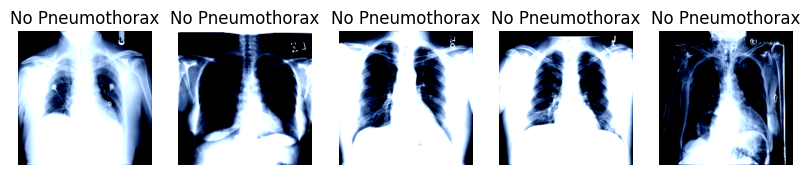

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


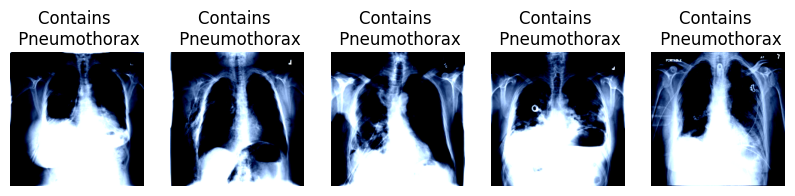

In [31]:
# Collect samples from each class
class_0_samples = []
class_1_samples = []
for images, labels in test_loader:
    for i in range(len(labels)):
        if labels[i] == 0 and len(class_0_samples) < 5:
            class_0_samples.append(images[i])
        elif labels[i] == 1 and len(class_1_samples) < 5:
            class_1_samples.append(images[i])
    if len(class_0_samples) == 5 and len(class_1_samples) == 5:
        break

# No Pneumothorax
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.transpose(class_0_samples[i], (1, 2, 0)))
    plt.title("No Pneumothorax")
    plt.axis('off')
plt.show()

# Pneumothorax
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.transpose(class_1_samples[i], (1, 2, 0)))
    plt.title("Contains \n Pneumothorax")
    plt.axis('off')
plt.show()